In [1]:
import numpy as np
import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import rasterio
import heapq
from scipy.ndimage import sobel
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from skimage.measure import block_reduce

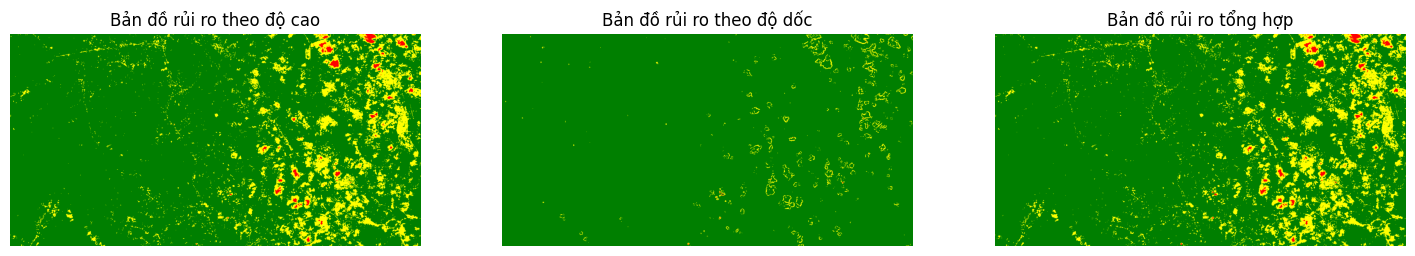

In [2]:
# Đọc dữ liệu độ cao từ file GeoTIFF
file_path = r"C:\Users\Admin\Downloads\D23022025.tif"
with rasterio.open(file_path) as dataset:
    elevation = dataset.read(1)  # Lấy kênh độ cao
    profile = dataset.profile

# Tính toán độ dốc bằng đạo hàm Sobel3
dx = sobel(elevation, axis=1)  # Gradient theo trục x
dy = sobel(elevation, axis=0)  # Gradient theo trục y
slope = np.hypot(dx, dy)  # Độ dốc tổng hợp

# Chuẩn hóa dữ liệu
elevation_norm = (elevation - np.min(elevation)) / (np.max(elevation) - np.min(elevation))
slope_norm = (slope - np.min(slope)) / (np.max(slope) - np.min(slope))

# Xây dựng bản đồ rủi ro riêng lẻ
risk_elevation = np.zeros_like(elevation_norm)
risk_slope = np.zeros_like(slope_norm)

risk_elevation[elevation_norm < 0.3] = 0  # An toàn
risk_elevation[(elevation_norm >= 0.3) & (elevation_norm < 0.7)] = 0.5  # Trung bình
risk_elevation[elevation_norm >= 0.7] = 1  # Nguy hiểm

risk_slope[slope_norm < 0.3] = 0  # An toàn
risk_slope[(slope_norm >= 0.3) & (slope_norm < 0.7)] = 0.5  # Trung bình
risk_slope[slope_norm >= 0.7] = 1  # Nguy hiểm


risk_combined = np.maximum(risk_elevation, risk_slope)

# Hàm chuyển dữ liệu rủi ro thành ảnh màu
def generate_risk_map(risk_data):
    risk_map = np.zeros((*risk_data.shape, 3))  # Ảnh màu (H, W, 3)
    risk_map[risk_data < 0.3] = [0, 0.5, 0]  # Xanh (An toàn)
    risk_map[(risk_data >= 0.3) & (risk_data < 0.7)] = [1, 1, 0]  # Vàng (Trung bình)
    risk_map[risk_data >= 0.7] = [1, 0, 0]  # Đỏ (Nguy hiểm)
    return risk_map

# Tạo ảnh màu cho 3 bản đồ
risk_map_elevation = generate_risk_map(risk_elevation)
risk_map_slope = generate_risk_map(risk_slope)
risk_map_combined = generate_risk_map(risk_combined)

# Hiển thị cả 3 bản đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(risk_map_elevation)
axes[0].set_title("Bản đồ rủi ro theo độ cao")
axes[0].axis("off")

axes[1].imshow(risk_map_slope)
axes[1].set_title("Bản đồ rủi ro theo độ dốc")
axes[1].axis("off")

axes[2].imshow(risk_map_combined)
axes[2].set_title("Bản đồ rủi ro tổng hợp")
axes[2].axis("off")

plt.show()


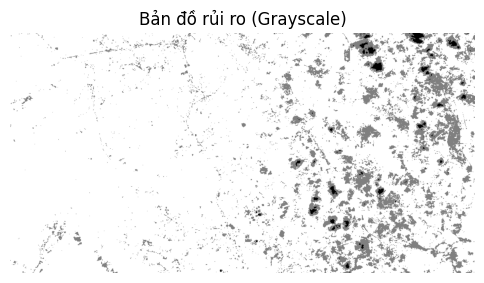

In [3]:
# Chuyển bản đồ rủi ro thành grayscale
def generate_grayscale_risk_map(risk_data):
    grayscale_map = np.zeros_like(risk_data, dtype=np.uint8)
    grayscale_map[risk_data < 0.3] = 150 # An toàn (màu xám nhạt)
    grayscale_map[(risk_data >= 0.3) & (risk_data < 0.7)] = 100 # Trung bình (xám trung bình)
    grayscale_map[risk_data >= 0.7] = 50  # Nguy hiểm (xám đậm)
    return grayscale_map

# Tạo ảnh grayscale từ risk_map_combined
grayscale_risk_map = generate_grayscale_risk_map(risk_combined)

# Hiển thị ảnh grayscale
plt.figure(figsize=(6, 6))
plt.imshow(grayscale_risk_map, cmap='gray')
plt.title("Bản đồ rủi ro (Grayscale)")
plt.axis("off")
plt.show()


Episode 43/200, Score: -3435.400000000485, Epsilon: 0.81
Episode 44/200, Score: -2516.600000000124, Epsilon: 0.80
Episode 45/200, Score: -199.80000000000038, Epsilon: 0.80
Episode 46/200, Score: -65.0, Epsilon: 0.79


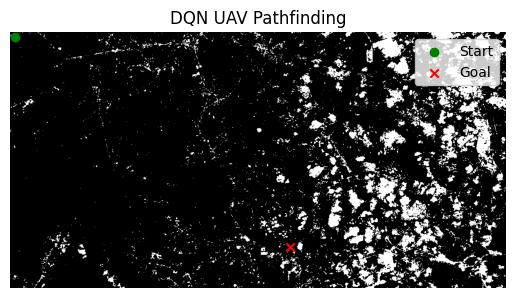

Episode 47/200, Score: -258.00000000000034, Epsilon: 0.79
Episode 48/200, Score: -167.80000000000035, Epsilon: 0.79
Episode 49/200, Score: -162.00000000000037, Epsilon: 0.78
Episode 50/200, Score: -208.20000000000027, Epsilon: 0.78
Episode 51/200, Score: -290.00000000000017, Epsilon: 0.77


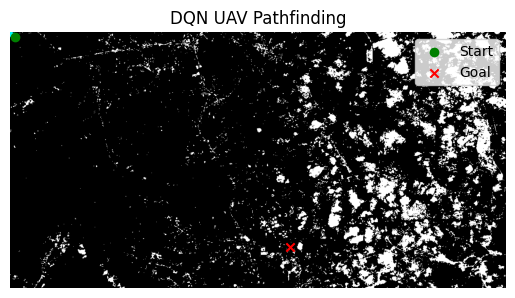

Episode 52/200, Score: -442.9999999999976, Epsilon: 0.77
Episode 53/200, Score: -148.4000000000011, Epsilon: 0.77
Episode 54/200, Score: -5894.999999999452, Epsilon: 0.76
Episode 55/200, Score: -1125.399999999988, Epsilon: 0.76
Episode 56/200, Score: -1238.3999999999996, Epsilon: 0.76


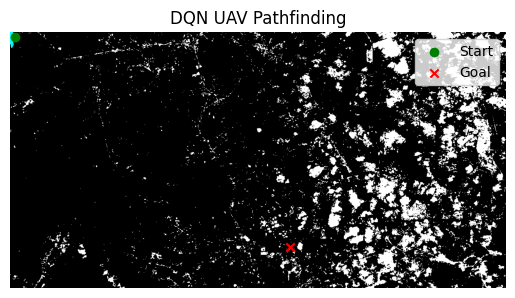

Episode 57/200, Score: -4616.600000000107, Epsilon: 0.75


KeyboardInterrupt: 

In [ ]:
# DQN Agent
class DQN_Agent:
    def __init__(self, state_size, action_size, model_path="dqn_model.h5"):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.002
        self.model = self.build_model()
        self.model_path = model_path

        # Load mô hình nếu có
        self.load_model()

    def build_model(self):
        model = Sequential([
            Dense(24, input_dim=self.state_size, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model
    
    def save_model(self):
        """ Lưu trọng số mô hình và epsilon để tiếp tục huấn luyện """
        self.model.save(self.model_path)
        with open(self.model_path.replace(".h5", "_epsilon.txt"), "w") as f:
            f.write(str(self.epsilon))
        print(f"Đã lưu mô hình vào {self.model_path}")

    def load_model(self):
        """ Tải mô hình đã lưu nếu tồn tại """
        if os.path.exists(self.model_path):
            self.model = tf.keras.models.load_model(self.model_path)
            epsilon_path = self.model_path.replace(".h5", "_epsilon.txt")
            if os.path.exists(epsilon_path):
                with open(epsilon_path, "r") as f:
                    self.epsilon = float(f.read().strip())
            print(f"Đã tải mô hình từ {self.model_path}, Epsilon: {self.epsilon:.4f}")
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.array(state).reshape(1, -1)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])
    
    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = np.array(next_state).reshape(1, -1)
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0))
            state = np.array(state).reshape(1, -1)
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


class UAV_Env:
    def __init__(self, risk_map, start, goal):
        self.risk_map = risk_map
        self.start = start
        self.goal = goal
        self.state = start
        self.actions = [
            ((0, 1), 1), ((1, 0), 1), ((0, -1), 1), ((-1, 0), 1),  # Lên, Xuống, Trái, Phải
            ((1, 1), 1.4), ((1, -1), 1.4), ((-1, 1), 1.4), ((-1, -1), 1.4) # Đường chéo
        ]
        self.rows, self.cols = risk_map.shape[:2]
        self.steps_in_risk = 0  # Đếm số bước UAV đi trong vùng nguy hiểm
        self.MAX_STEPS_IN_RISK = 6  # Giới hạn số bước UAV có thể tồn tại trong vùng nguy hiểm
        self.max_consecutive_failures = 50  # Giới hạn số lần UAV đi xa khỏi đích liên tiếp
        self.consecutive_failures = 0

    def reset(self):
        self.state = self.start
        self.steps_in_risk = 0  # Reset bộ đếm vùng nguy hiểm khi bắt đầu lại
        self.consecutive_failures = 0
        return self.state

    def step(self, action):
        """ Thực hiện hành động và trả về (next_state, reward, done) """
        (dr, dc), move_cost = self.actions[action]
        row, col = self.state
        new_row, new_col = row + dr, col + dc

        if not (0 <= new_row < self.rows and 0 <= new_col < self.cols):
            new_row, new_col = row, col  # Giữ nguyên vị trí nếu đi ra ngoài bản đồ

        self.state = (new_row, new_col)  # Cập nhật vị trí UAV

        old_distance = abs(row - self.goal[0]) + abs(col - self.goal[1])
        new_distance = abs(new_row - self.goal[0]) + abs(new_col - self.goal[1])

        done = False  # Khởi tạo trạng thái chưa kết thúc

        if self.state == self.goal:
            reward = 5000  # Tăng phần thưởng để khuyến khích UAV đến đích
            done = True

        elif self.risk_map[self.state] >= 0.8:  # UAV đi vào vùng nguy hiểm
            if new_distance < old_distance:
                self.steps_in_risk = max(0, self.steps_in_risk - 1)  # Giảm số bước nguy hiểm nếu tiến về đích
                reward = -1 - move_cost
            else:
                self.steps_in_risk += 1  # Tăng số bước nguy hiểm nếu đi sai hướng
                reward = -10 - move_cost
            done = self.steps_in_risk >= self.MAX_STEPS_IN_RISK  # Nếu quá số bước cho phép, kết thúc

        else:  # UAV ở vùng an toàn
            self.steps_in_risk = 0  # Reset bước đi trong vùng nguy hiểm
            if new_distance < old_distance:
                reward = (old_distance - new_distance) * 2 - move_cost
                self.consecutive_failures = 0
            else:
                reward = -move_cost
                self.consecutive_failures += 1
            done = self.consecutive_failures >= self.max_consecutive_failures  # Kiểm tra điều kiện thất bại liên tục

        return self.state, reward, done

    def render(self, path=[]):
        img = (self.risk_map * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        for (r, c) in path:
            cv2.circle(img, (c, r), 1, (0, 255, 255), -1)  # Đường đi màu Cyan

        plt.imshow(img)
        plt.scatter(self.start[1], self.start[0], color="green", marker="o", label="Start")
        plt.scatter(self.goal[1], self.goal[0], color="red", marker="x", label="Goal")
        plt.legend()
        plt.title("DQN UAV Pathfinding")
        plt.axis("off")
        plt.show()


# Load Risk Map
risk_map = risk_map_combined[:, :, 0]
start = (50, 50)
goal = (500, 750)

env = UAV_Env(risk_map, start, goal)
agent = DQN_Agent(state_size=2, action_size=len(env.actions))

episodes = 50
for e in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    path = []
    
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        path.append(state)
    
    agent.train()
    
    print(f"Episode {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.4f}")
    
    if e % 5 == 0:
        env.render(path)
    
    if e % 10 == 0:
        agent.save_model()
